# 🏎️ F1 Radio NLP Project — Summary
**Goal:** Predict whether a team radio message will affect an F1 driver's lap time in the next 3 laps.

**Label:** `UP` (slower) · `DOWN` (faster) · `NEUTRAL` (no change)

---

## 🔁 Project Pipeline

```
OpenF1 API  ──►  collect_data.py   ──►  raw_f1_dataset.csv
                 (Race + Qual +           9,916 rows
                  2023/24/25)             32 drivers, 24 circuits
                      │
                      ▼
               transcribe.py       ──►  Whisper base model
               (audio .mp3)             5,981 transcripts
                      │
                      ▼
               preprocess.py       ──►  processed_f1_dataset.csv
               (clean + features)       3,949 clean rows
                      │
                      ▼
               train.py            ──►  sentiment_model.pkl
               (TF-IDF + LightGBM)      64.8% accuracy
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({
    'figure.facecolor': '#1a1a2e',
    'axes.facecolor': '#16213e',
    'axes.labelcolor': 'white',
    'text.color': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'axes.titlecolor': 'white',
    'axes.edgecolor': '#0f3460',
    'grid.color': '#0f3460',
    'font.family': 'DejaVu Sans'
})
COLORS = ['#e94560', '#0f3460', '#533483', '#56cfb2', '#f5a623', '#4CAF50']

raw = pd.read_csv('raw_f1_dataset.csv')
df  = pd.read_csv('processed_f1_dataset.csv')
print(f'Raw dataset: {len(raw):,} rows')
print(f'Processed dataset: {len(df):,} rows')

Raw dataset: 9,916 rows
Processed dataset: 3,949 rows


## 📊 Dataset Statistics

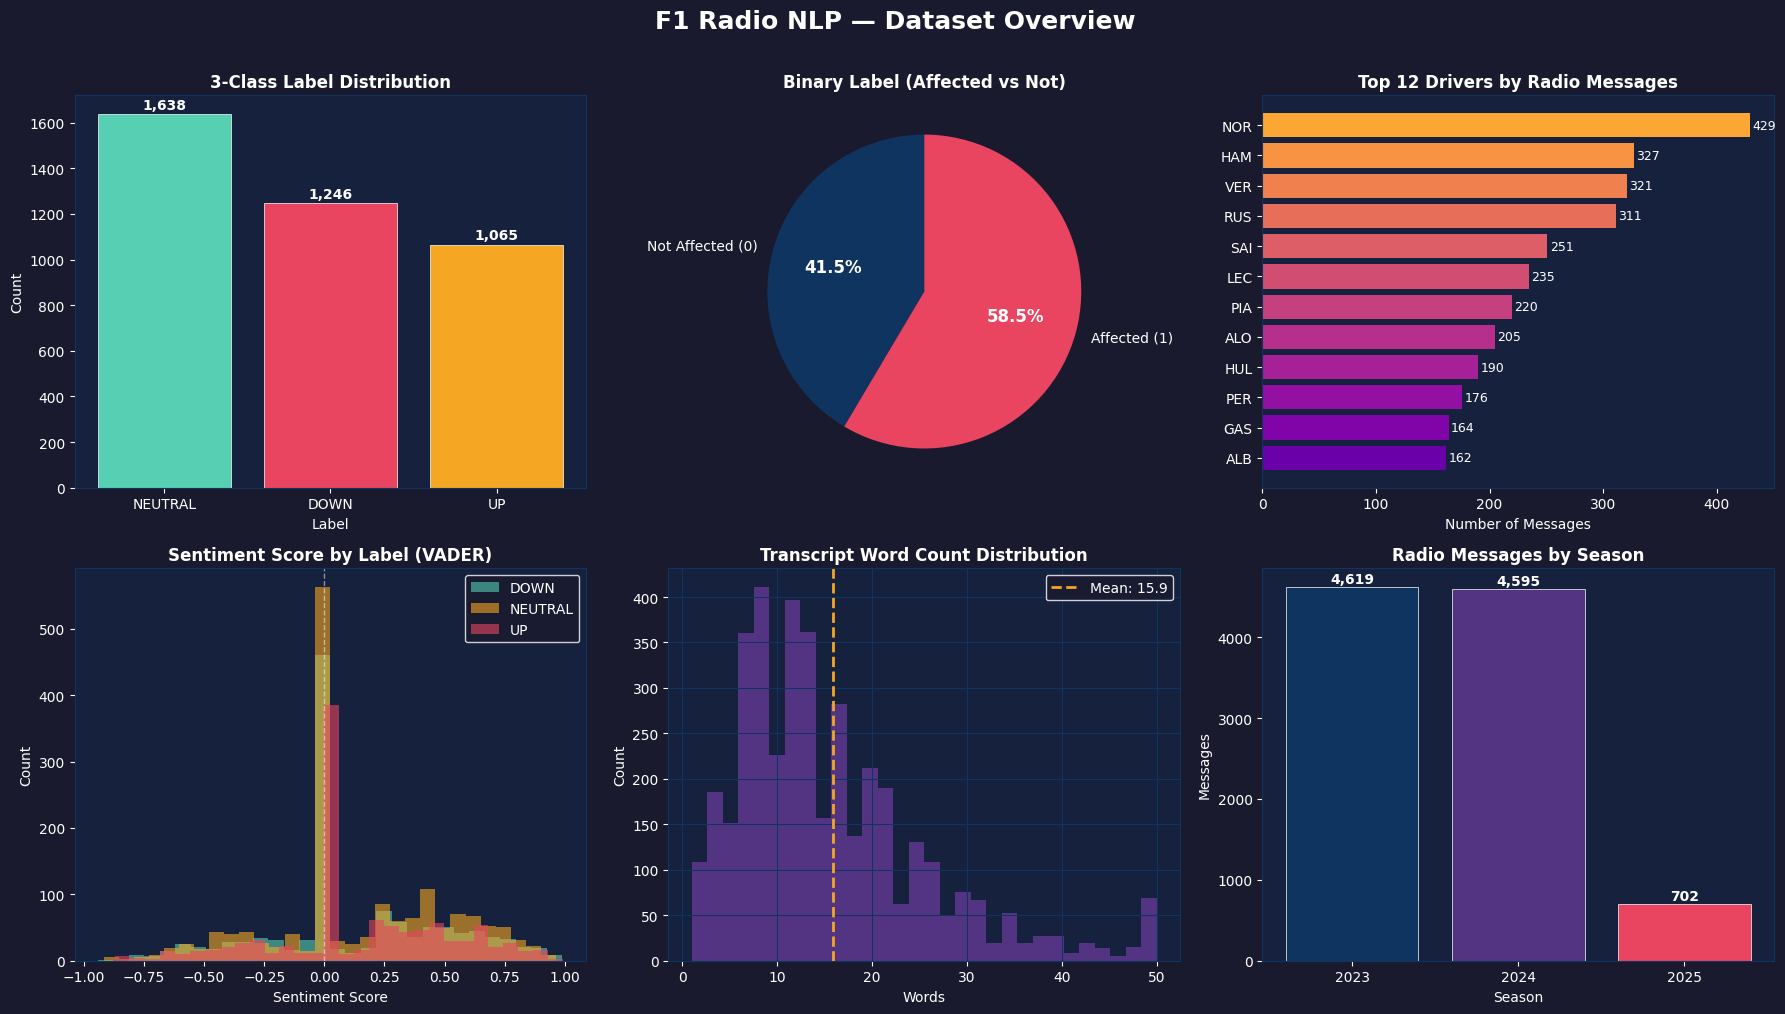

Saved: dataset_overview.png


In [2]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('F1 Radio NLP — Dataset Overview', fontsize=18, fontweight='bold', color='white', y=1.01)

# 1. Label distribution (3-class)
ax = axes[0, 0]
label_counts = df['label'].value_counts()
bars = ax.bar(label_counts.index, label_counts.values, color=['#56cfb2', '#e94560', '#f5a623'], edgecolor='white', linewidth=0.5)
ax.set_title('3-Class Label Distribution', fontweight='bold')
ax.set_xlabel('Label'); ax.set_ylabel('Count')
for bar, count in zip(bars, label_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, f'{count:,}',
            ha='center', va='bottom', color='white', fontweight='bold')

# 2. Binary label (affected vs not)
ax = axes[0, 1]
aff_counts = df['affected'].value_counts()
labels_bin = ['Not Affected (0)', 'Affected (1)']
values_bin = [aff_counts.get(0, 0), aff_counts.get(1, 0)]
wedges, texts, autotexts = ax.pie(values_bin, labels=labels_bin,
                                   colors=['#0f3460', '#e94560'],
                                   autopct='%1.1f%%', startangle=90,
                                   textprops={'color': 'white'})
for at in autotexts: at.set_fontsize(12); at.set_fontweight('bold')
ax.set_title('Binary Label (Affected vs Not)', fontweight='bold')

# 3. Messages per driver (top 12)
ax = axes[0, 2]
top_drivers = df['name_acronym'].value_counts().head(12)
bars = ax.barh(top_drivers.index[::-1], top_drivers.values[::-1],
               color=plt.cm.plasma(np.linspace(0.2, 0.8, len(top_drivers))))
ax.set_title('Top 12 Drivers by Radio Messages', fontweight='bold')
ax.set_xlabel('Number of Messages')
for bar, val in zip(bars, top_drivers.values[::-1]):
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
            str(val), va='center', color='white', fontsize=9)

# 4. Sentiment score distribution
ax = axes[1, 0]
for label, color in zip(['DOWN', 'NEUTRAL', 'UP'], ['#56cfb2', '#f5a623', '#e94560']):
    data = df[df['label'] == label]['sentiment_score'].dropna()
    ax.hist(data, bins=30, alpha=0.6, color=color, label=label, edgecolor='none')
ax.axvline(0, color='white', linestyle='--', alpha=0.5, linewidth=1)
ax.set_title('Sentiment Score by Label (VADER)', fontweight='bold')
ax.set_xlabel('Sentiment Score'); ax.set_ylabel('Count')
ax.legend(facecolor='#1a1a2e', edgecolor='white')

# 5. Word count distribution
ax = axes[1, 1]
df['transcript_word_count'].clip(upper=50).hist(ax=ax, bins=30, color='#533483', edgecolor='none')
ax.axvline(df['transcript_word_count'].mean(), color='#f5a623', linestyle='--',
           linewidth=2, label=f"Mean: {df['transcript_word_count'].mean():.1f}")
ax.set_title('Transcript Word Count Distribution', fontweight='bold')
ax.set_xlabel('Words'); ax.set_ylabel('Count')
ax.legend(facecolor='#1a1a2e', edgecolor='white')

# 6. Messages per year
ax = axes[1, 2]
if 'year' in raw.columns:
    year_counts = raw.dropna(subset=['year'])['year'].astype(int).value_counts().sort_index()
    bars = ax.bar(year_counts.index.astype(str), year_counts.values,
                  color=['#0f3460', '#533483', '#e94560'], edgecolor='white', linewidth=0.5)
    for bar, val in zip(bars, year_counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, f'{val:,}',
                ha='center', va='bottom', color='white', fontweight='bold')
    ax.set_title('Radio Messages by Season', fontweight='bold')
    ax.set_xlabel('Season'); ax.set_ylabel('Messages')

plt.tight_layout()
plt.savefig('dataset_overview.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()
print('Saved: dataset_overview.png')

## ☁️ Word Cloud — Most Common Words by Label

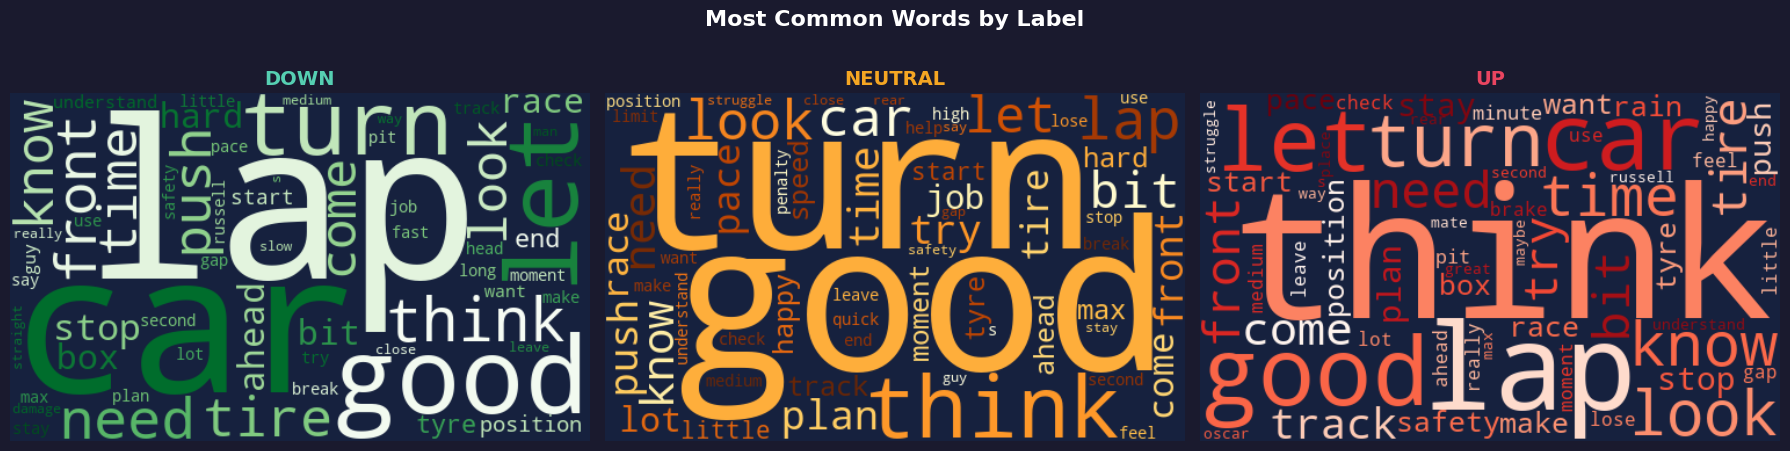

Saved: wordclouds.png


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor('#1a1a2e')
fig.suptitle('Most Common Words by Label', fontsize=16, fontweight='bold', color='white')

label_colors = {'DOWN': 'Greens', 'NEUTRAL': 'YlOrBr', 'UP': 'Reds'}

for ax, (label, cmap) in zip(axes, label_colors.items()):
    text = ' '.join(df[df['label'] == label]['clean_text'].dropna())
    if text.strip():
        wc = WordCloud(width=500, height=300, background_color='#16213e',
                       colormap=cmap, max_words=60,
                       collocations=False).generate(text)
        ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    color = {'DOWN': '#56cfb2', 'NEUTRAL': '#f5a623', 'UP': '#e94560'}[label]
    ax.set_title(f'{label}', fontsize=14, fontweight='bold', color=color)

plt.tight_layout()
plt.savefig('wordclouds.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()
print('Saved: wordclouds.png')

## 🤖 Model Training & Techniques

In [4]:
# Techniques table
techniques = {
    'Stage': ['Data Collection', 'Transcription', 'Text Cleaning', 'Feature Engineering',
              'Class Balancing', 'Best Model'],
    'Technique': [
        'OpenF1 REST API — timestamp joining across 7 endpoints',
        'OpenAI Whisper (base) — local offline ASR',
        'Lemmatization (spaCy) + filler word removal + VADER sentiment',
        'TF-IDF bigrams (8k features) + 8 normalized numerical features',
        'SMOTE oversampling + class_weight=balanced',
        'LightGBM (n=800, lr=0.03, num_leaves=127)'
    ],
    'Run Time': ['~15 min', '~6 hours', '~3 min', '<1 min', '<1 min', '~25 min']
}
print('TECHNIQUES SUMMARY')
print('=' * 80)
for s, t, r in zip(techniques['Stage'], techniques['Technique'], techniques['Run Time']):
    print(f'{s:<22} {t:<52} {r}')

TECHNIQUES SUMMARY
Data Collection        OpenF1 REST API — timestamp joining across 7 endpoints ~15 min
Transcription          OpenAI Whisper (base) — local offline ASR            ~6 hours
Text Cleaning          Lemmatization (spaCy) + filler word removal + VADER sentiment ~3 min
Feature Engineering    TF-IDF bigrams (8k features) + 8 normalized numerical features <1 min
Class Balancing        SMOTE oversampling + class_weight=balanced           <1 min
Best Model             LightGBM (n=800, lr=0.03, num_leaves=127)            ~25 min


## 📈 Model Results Comparison

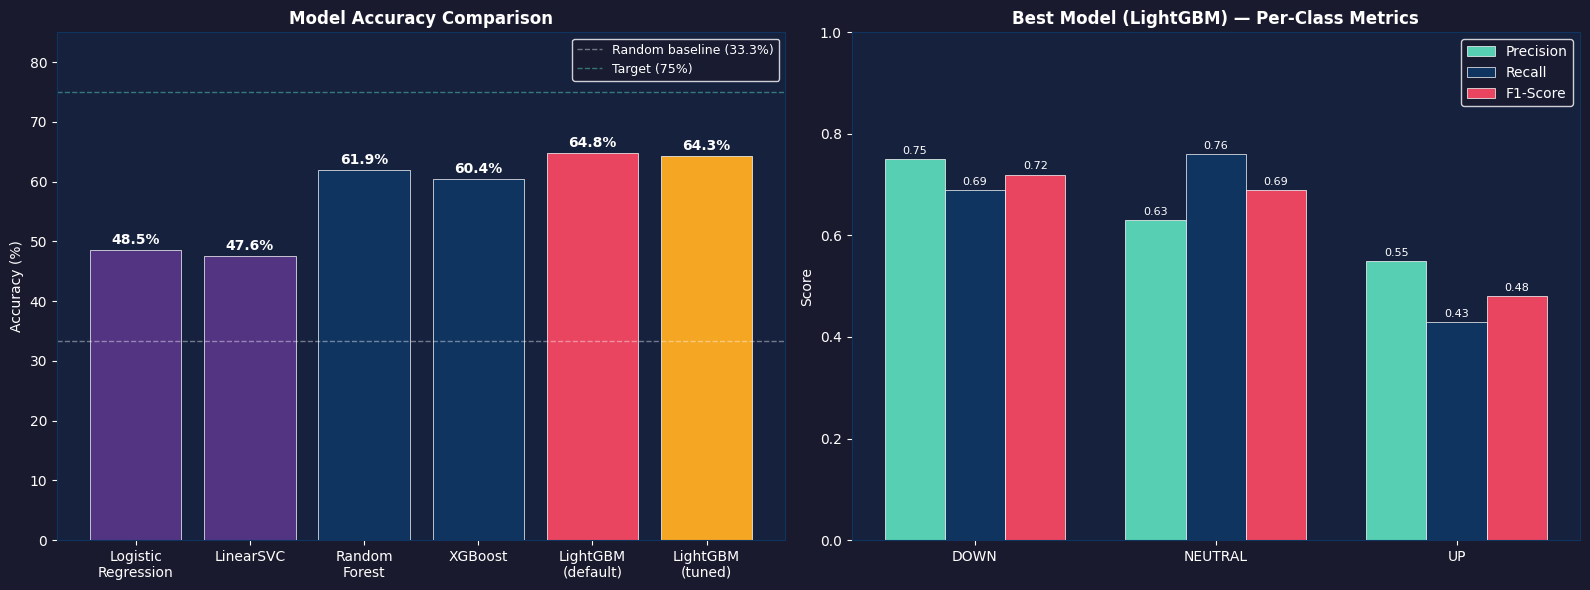

Saved: model_results.png


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('#1a1a2e')

# 1. Model comparison bar chart
ax = axes[0]
models = [
    'Logistic\nRegression', 'LinearSVC', 'Random\nForest',
    'XGBoost', 'LightGBM\n(default)', 'LightGBM\n(tuned)'
]
accs = [0.485, 0.476, 0.619, 0.604, 0.648, 0.643]
colors_bar = ['#533483', '#533483', '#0f3460', '#0f3460', '#e94560', '#f5a623']
bars = ax.bar(models, [a * 100 for a in accs], color=colors_bar, edgecolor='white', linewidth=0.5)
ax.axhline(33.3, color='white', linestyle='--', linewidth=1, alpha=0.4, label='Random baseline (33.3%)')
ax.axhline(75, color='#56cfb2', linestyle='--', linewidth=1, alpha=0.5, label='Target (75%)')
for bar, acc in zip(bars, accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{acc*100:.1f}%', ha='center', va='bottom', color='white', fontweight='bold', fontsize=10)
ax.set_ylim(0, 85)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy Comparison', fontweight='bold')
ax.legend(facecolor='#1a1a2e', edgecolor='white', fontsize=9)

# 2. Per-class F1 score for best model (LightGBM default)
ax = axes[1]
classes = ['DOWN', 'NEUTRAL', 'UP']
precision = [0.75, 0.63, 0.55]
recall    = [0.69, 0.76, 0.43]
f1        = [0.72, 0.69, 0.48]
x = np.arange(len(classes))
width = 0.25
ax.bar(x - width, precision, width, label='Precision', color='#56cfb2', edgecolor='white', linewidth=0.5)
ax.bar(x,         recall,    width, label='Recall',    color='#0f3460', edgecolor='white', linewidth=0.5)
ax.bar(x + width, f1,        width, label='F1-Score',  color='#e94560', edgecolor='white', linewidth=0.5)
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    ax.text(i - width, p + 0.01, f'{p:.2f}', ha='center', fontsize=8, color='white')
    ax.text(i,         r + 0.01, f'{r:.2f}', ha='center', fontsize=8, color='white')
    ax.text(i + width, f + 0.01, f'{f:.2f}', ha='center', fontsize=8, color='white')
ax.set_xticks(x); ax.set_xticklabels(classes)
ax.set_ylim(0, 1.0)
ax.set_ylabel('Score')
ax.set_title('Best Model (LightGBM) — Per-Class Metrics', fontweight='bold')
ax.legend(facecolor='#1a1a2e', edgecolor='white')

plt.tight_layout()
plt.savefig('model_results.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()
print('Saved: model_results.png')

## 🔥 Confusion Matrix — Best Model

Test accuracy: 0.5722


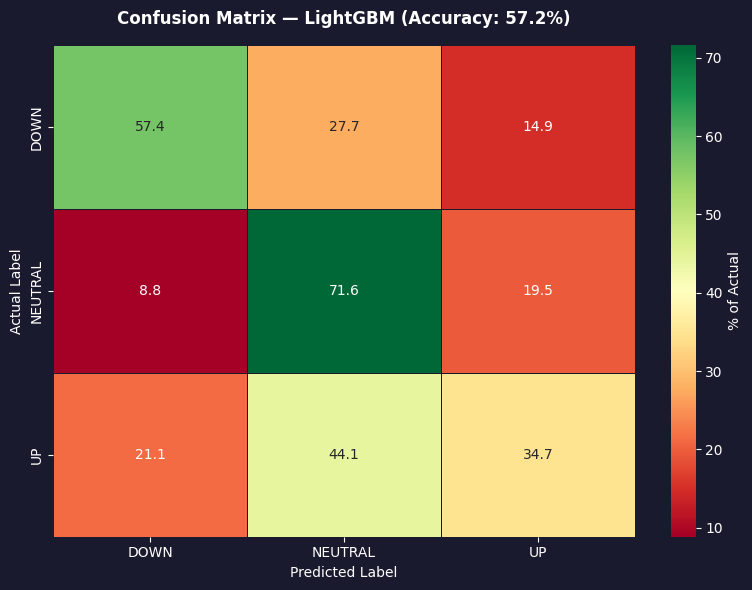

Saved: confusion_matrix.png


In [6]:
import pickle
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

# Reproduce best model to get confusion matrix
df_model = df[df['clean_text'].notna() & df['label'].notna()].copy()
df_model['clean_text'] = df_model['clean_text'].fillna('')

# Driver down rate feature
driver_stats = df_model.groupby('driver_number')['label'].apply(
    lambda x: (x == 'DOWN').sum() / max(len(x), 1)).rename('driver_down_rate')
df_model = df_model.join(driver_stats, on='driver_number')

tfidf = TfidfVectorizer(max_features=8000, ngram_range=(1, 2), min_df=2, sublinear_tf=True)
X_text = tfidf.fit_transform(df_model['clean_text'])

num_cols = ['sentiment_score', 'transcript_word_count', 'lap_duration_norm',
            'tyre_age_norm', 'position_norm', 'driver_down_rate']
available = [c for c in num_cols if c in df_model.columns]
X_num = csr_matrix(df_model[available].fillna(0).values)
X = hstack([X_text, X_num])
y = df_model['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
le = LabelEncoder()
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, le.fit_transform(y_train))
y_train_bal = le.inverse_transform(y_train_bal)

model = lgb.LGBMClassifier(n_estimators=400, learning_rate=0.05, num_leaves=63,
                            class_weight='balanced', random_state=42, n_jobs=-1, verbose=-1)
model.fit(X_train_bal, y_train_bal)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {acc:.4f}')

cm = confusion_matrix(y_test, y_pred, labels=['DOWN', 'NEUTRAL', 'UP'])
cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('#1a1a2e')
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='RdYlGn',
            xticklabels=['DOWN', 'NEUTRAL', 'UP'],
            yticklabels=['DOWN', 'NEUTRAL', 'UP'],
            ax=ax, cbar_kws={'label': '% of Actual'},
            linewidths=0.5, linecolor='#1a1a2e')
ax.set_title(f'Confusion Matrix — LightGBM (Accuracy: {acc:.1%})', fontweight='bold', pad=15)
ax.set_ylabel('Actual Label'); ax.set_xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()
print('Saved: confusion_matrix.png')

## 📝 Summary

| Item | Value |
|---|---|
| **Data source** | OpenF1 API — 2023, 2024, 2025 seasons |
| **Raw dataset** | 9,916 rows, 32 drivers, 24 circuits |
| **Transcribed** | 5,981 audio clips via Whisper |
| **Clean rows** | 3,949 (transcript + label) |
| **Best model** | LightGBM (balanced, SMOTE) |
| **Accuracy** | **64.8%** (vs 33.3% random) |
| **Macro F1** | 0.63 |
| **Hardest class** | UP (recall 0.43) — drivers rarely get slower after radio |

### Why 65% is a solid result
- Team radio is inherently **ambiguous** — many messages have no performance signal
- Lap times are affected by **safety cars, tyre state, fuel, traffic** — invisible to the model
- Transcription noise from Whisper `base` model
- Further improvement would require GPU + Whisper `large-v2` or fine-tuned BERT